# Cleaning the data ...

Libraries for Project ...

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from meteostat import Point, Hourly

Load Data ...

In [2]:
Org_data = pd.read_csv("/home/malaka/Projects/CV_Projects/Datasets/Org_data.csv")
Org_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


Handle Missing Values

In [3]:
print(Org_data.isnull().sum())

# Example: Drop rows with missing latitude or longitude (important for geospatial analysis)
df = Org_data.dropna(subset=['LAT', 'LON'])

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           147473
Vict Age               0
Vict Sex          140607
Vict Descent      140619
Premis Cd             16
Premis Desc          582
Weapon Used Cd    661838
Weapon Desc       661838
Status                 1
Status Desc            0
Crm Cd 1              11
Crm Cd 2          918239
Crm Cd 3          984577
Crm Cd 4          986813
LOCATION               0
Cross Street      834910
LAT                    0
LON                    0
dtype: int64


In [4]:
# Filter rows where both LAT and LON are 0
zero_values = Org_data[(Org_data['LAT'] == 0) & (Org_data['LON'] == 0)]

# Display the rows
# print(zero_values)
zero_count = zero_values.shape[0]
print(f"Number of rows with LAT and LON as 0,0: {zero_count}")
df = Org_data[~((Org_data['LAT'] == 0) & (Org_data['LON'] == 0))]



Number of rows with LAT and LON as 0,0: 2103


Standardise Column Data

In [5]:
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])   
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])   
df['DATE OCC'][1]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Timestamp('2020-02-08 00:00:00')

Ensure numerical fields 

In [6]:
df['Vict Age'] = pd.to_numeric(df['Vict Age'], errors='coerce')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Remove Unnecessary Columns

In [7]:
df = df.drop(['DR_NO', 'Cross Street'], axis=1)

Add Derived Features

In [8]:
# Extract year and month from 'DATE OCC'
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month

Encode Categorical Variables

In [9]:
# df['Vict Sex']

0           M
1           M
2           X
3           M
4         NaN
         ... 
986868    NaN
986869      X
986870      M
986871      F
986872    NaN
Name: Vict Sex, Length: 984770, dtype: object

In [9]:
df['Vict Sex'] = df['Vict Sex'].map({'M': 0, 'F': 1, 'X': 2}).fillna(3) # 'X' for unknown
df['Vict Sex']

0         0.0
1         0.0
2         2.0
3         0.0
4         3.0
         ... 
986868    3.0
986869    2.0
986870    0.0
986871    1.0
986872    3.0
Name: Vict Sex, Length: 984770, dtype: float64

Check for Duplicates

In [10]:
print(df.duplicated().sum())
df = df.drop_duplicates()


55977


In [12]:
df.describe()

,Date Rptd,DATE OCC,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Sex,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON,Year,Month
count,928793,928793,928793.000000,928793.000000,928793.000000,928793.000000,928793.000000,928793.000000,928793.000000,928778.000000,304476.000000,928782.000000,63731.000000,2099.000000,56.000000,928793.000000,928793.000000,928793.000000,928793.000000
mean,2022-06-06 11:52:42.740891136,2022-05-27 01:03:20.028639488,1339.651659,10.236165,1070.035142,1.399177,499.775398,28.894103,0.982494,305.308272,364.137564,499.540004,959.107797,984.585040,990.232143,34.069912,-118.351211,2021.923181,6.276573
min,2020-01-01 00:00:00,2020-01-01 00:00:00,1.000000,1.000000,101.000000,1.000000,110.000000,-4.000000,0.000000,101.000000,101.000000,110.000000,210.000000,310.000000,821.000000,33.705900,-118.667600,2020.000000,1.000000
25%,2021-04-13 00:00:00,2021-03-28 00:00:00,900.000000,5.000000,555.000000,1.000000,331.000000,0.000000,0.000000,101.000000,311.000000,331.000000,998.000000,998.000000,998.000000,34.014500,-118.426000,2021.000000,3.000000
50%,2022-07-19 00:00:00,2022-07-07 00:00:00,1420.000000,10.000000,1063.000000,1.000000,442.000000,30.000000,1.000000,203.000000,400.000000,442.000000,998.000000,998.000000,998.000000,34.056700,-118.320600,2022.000000,6.000000
75%,2023-07-18 00:00:00,2023-07-08 00:00:00,1900.000000,15.000000,1525.000000,2.000000,626.000000,44.000000,1.000000,501.000000,400.000000,626.000000,998.000000,998.000000,998.000000,34.153800,-118.273800,2023.000000,9.000000
max,2024-11-24 00:00:00,2024-11-24 00:00:00,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,3.000000,976.000000,516.000000,956.000000,999.000000,999.000000,999.000000,34.334300,-118.155400,2024.000000,12.000000
std,NaN,NaN,651.792276,5.972475,597.321203,0.489730,205.247164,21.988695,1.035491,219.558651,123.799574,205.047593,109.245269,51.941154,28.834317,0.109125,0.102377,1.329513,3.437122


#### Combine DATE OCC and TIME OCC into a Single Datetime Column
You must first convert DATE OCC and TIME OCC into a single Datetime column to align with Meteostat's time requirements.

In [13]:
# Function to convert TIME OCC (e.g., 630, 2130) to HH:MM format
def convert_time(time):
    time = f"{int(time):04}"  # Ensures time is zero-padded (e.g., 630 -> 0630)
    return f"{time[:2]}:{time[2:]}"  # Returns in 'HH:MM' format

# Combine DATE OCC and TIME OCC into a single datetime column
df['TIME OCC'] = df['TIME OCC'].apply(convert_time)
df['Date/Time'] = pd.to_datetime(df['DATE OCC'].astype(str) + ' ' + df['TIME OCC'], format='%Y-%m-%d %H:%M')

# Display the result
# print(df[['DATE OCC', 'TIME OCC', 'Date/Time']].head())



Statistical Summary

In [ ]:
# print(df.describe())


                           Date Rptd                       DATE OCC  \
count                         928793                         928793   
mean   2022-06-06 11:52:42.740891136  2022-05-27 01:03:20.028639488   
min              2020-01-01 00:00:00            2020-01-01 00:00:00   
25%              2021-04-13 00:00:00            2021-03-28 00:00:00   
50%              2022-07-19 00:00:00            2022-07-07 00:00:00   
75%              2023-07-18 00:00:00            2023-07-08 00:00:00   
max              2024-11-24 00:00:00            2024-11-24 00:00:00   
std                              NaN                            NaN   

                AREA    Rpt Dist No       Part 1-2         Crm Cd  \
count  928793.000000  928793.000000  928793.000000  928793.000000   
mean       10.236165    1070.035142       1.399177     499.775398   
min         1.000000     101.000000       1.000000     110.000000   
25%         5.000000     555.000000       1.000000     331.000000   
50%        10.0

Summary of crimes that commited.

In [ ]:
# print(df['Crm Cd Desc'].value_counts())

In [14]:
df.sample(2)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,LAT,LON,Year,Month,Date/Time
214966,2021-10-23,2021-10-23,09:29,13,Newton,1363,2,901,VIOLATION OF RESTRAINING ORDER,0913,...,901.0,NaN,NaN,NaN,800 E 47TH ST,34.0007,-118.2618,2021,10,2021-10-23 09:29:00
532698,2022-05-24,2022-05-22,00:10,14,Pacific,1488,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0400 0408 1822 1236,...,230.0,NaN,NaN,NaN,5700 W CENTURY BL,33.9456,-118.3797,2022,5,2022-05-22 00:10:00


In [16]:
print(list(df.columns))

['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'LAT', 'LON', 'Year', 'Month', 'Date/Time']


#### Fetch Hourly Weather Data Using Meteostat
You will now fetch weather data for the entire date range in your crime dataset using the Meteostat Hourly class.

1. **Define the Location (LAT, LON) and Time Range:** Since your dataset contains LAT and LON for each crime, you can fetch weather data for Los Angeles.

2. **Fetch Weather Data:** Use the Hourly class from meteostat to download the weather data.

In [17]:

# Define the coordinates for Los Angeles (example)
location = Point(34.069912, -118.351211)  # Mean LAT, LON for Los Angeles

# Determine the start and end date from your dataset
start = df['Date/Time'].min()
end = df['Date/Time'].max()

# Fetch historical weather data
data_hourly = Hourly(location, start, end)
data_hourly = data_hourly.fetch()

# Ensure the index is a DatetimeIndex and remove timezone information
data_hourly.index = data_hourly.index.tz_localize(None)

# Resample hourly data to ensure proper merging (optional step)
data_hourly = data_hourly.resample('T').interpolate().reset_index()

# Select relevant columns
weather_df = data_hourly[['time', 'temp','dwpt','rhum', 'prcp', 'wdir','wspd',  'pres','tsun','wpgt', 'snow' ]]
weather_df = weather_df.rename(columns={
    'time': 'Date/Time', 
    'temp': 'Temperature (°C)',
    'dwpt': 'Dew point (°C)',
    'rhum': 'Humidity (%)',
    'prcp': 'Precipitation (mm)',
    'wdir': 'Wind Direction(degrees°)',
    'wspd': 'Windspeed (km/h)',
    'pres': 'Air pressure (hPa)',
    'tsun': 'Sunshine total(min)',
    'wpgt': 'Wind Gust (km/h)',
    'snow': 'Snow depth(mm)'
})

# Display weather data
weather_df.head()


,Date/Time,Temperature (°C),Dew point (°C),Humidity (%),Precipitation (mm),Wind Direction(degrees°),Windspeed (km/h),Air pressure (hPa),Sunshine total(min),Wind Gust (km/h),Snow depth(mm)
0,2020-01-01 01:00:00,21.1,1.4,27.0,0.0,0.0,0.0,1015.6,NaN,NaN,NaN
1,2020-01-01 02:00:00,19.4,-0.1,27.0,0.0,0.0,0.0,1016.2,NaN,NaN,NaN
2,2020-01-01 03:00:00,16.7,0.8,34.0,0.0,0.0,0.0,1016.7,NaN,NaN,NaN
3,2020-01-01 04:00:00,16.7,0.8,34.0,0.0,0.0,0.0,1017.3,NaN,NaN,NaN
4,2020-01-01 05:00:00,15.6,1.0,37.0,0.0,0.0,0.0,1017.8,NaN,NaN,NaN


In [18]:
weather_df.sample(5)

,Date/Time,Temperature (°C),Dew point (°C),Humidity (%),Precipitation (mm),Wind Direction(degrees°),Windspeed (km/h),Air pressure (hPa),Sunshine total(min),Wind Gust (km/h),Snow depth(mm)
14879,2021-09-12 00:00:00,28.3,12.6,38.0,0.0,260.0,5.4,1011.5,NaN,NaN,NaN
39828,2024-07-17 13:00:00,17.4,15.7,90.0,0.0,83.0,9.4,1014.7,NaN,NaN,NaN
23308,2022-08-29 05:00:00,18.3,16.6,90.0,0.0,0.0,0.0,1010.1,NaN,NaN,NaN
21630,2022-06-20 07:00:00,17.8,12.3,70.0,0.0,0.0,0.0,1012.3,NaN,NaN,NaN
6256,2020-09-17 17:00:00,26.7,5.0,25.0,0.0,0.0,0.0,1013.5,NaN,NaN,NaN


In [19]:
weather_df.describe()

,Date/Time,Temperature (°C),Dew point (°C),Humidity (%),Precipitation (mm),Wind Direction(degrees°),Windspeed (km/h),Air pressure (hPa),Sunshine total(min),Wind Gust (km/h),Snow depth(mm)
count,42955,42955.000000,42955.000000,42955.000000,42931.000000,42955.000000,42955.000000,42955.000000,0.0,0.0,0.0
mean,2022-06-13 22:00:00,18.178098,10.030965,63.267536,0.034173,100.474590,4.880123,1014.944607,NaN,NaN,NaN
min,2020-01-01 01:00:00,1.700000,-18.200000,4.000000,0.000000,0.000000,0.000000,997.000000,NaN,NaN,NaN
25%,2021-03-23 11:30:00,14.400000,7.200000,50.000000,0.000000,0.000000,0.000000,1012.200000,NaN,NaN,NaN
50%,2022-06-13 22:00:00,17.800000,11.600000,67.000000,0.000000,20.000000,5.000000,1014.500000,NaN,NaN,NaN
75%,2023-09-04 08:30:00,21.100000,14.500000,79.000000,0.000000,238.000000,7.600000,1017.400000,NaN,NaN,NaN
max,2024-11-24 19:00:00,43.200000,23.200000,100.000000,18.500000,360.000000,49.300000,1028.800000,NaN,NaN,NaN
std,NaN,5.202614,6.216192,20.420974,0.323381,115.782726,5.959458,3.870707,NaN,NaN,NaN


#### Merge Weather Data with Your Crime Dataset

Now that you have the weather data (weather_df) and a unified Date/Time column in your crime dataset, you can perform a left join to add the weather data.

In [20]:
# Merge weather data with the crime dataset
merged_df = pd.merge(df, weather_df, on='Date/Time', how='left')

# Check the final dataset
merged_df.sample(5)


,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Temperature (°C),Dew point (°C),Humidity (%),Precipitation (mm),Wind Direction(degrees°),Windspeed (km/h),Air pressure (hPa),Sunshine total(min),Wind Gust (km/h),Snow depth(mm)
0,2020-03-01,2020-03-01,21:30,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-09,2020-02-08,18:00,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,...,17.2,9.4,60.0,0.0,0.0,0.0,1017.2,NaN,NaN,NaN
2,2020-11-11,2020-11-04,17:00,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,...,21.7,11.7,53.0,0.0,0.0,0.0,1018.7,NaN,NaN,NaN
3,2023-05-10,2020-03-10,20:37,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-09,2020-09-09,06:30,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
merged_df.describe()

,Date Rptd,DATE OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Vict Sex,Premis Cd,Weapon Used Cd,...,Temperature (°C),Dew point (°C),Humidity (%),Precipitation (mm),Wind Direction(degrees°),Windspeed (km/h),Air pressure (hPa),Sunshine total(min),Wind Gust (km/h),Snow depth(mm)
count,928793,928793,928793.000000,928793.000000,928793.000000,928793.000000,928793.000000,928793.000000,928778.000000,304476.000000,...,361279.000000,361279.000000,361279.000000,361036.000000,361279.000000,361279.000000,361279.000000,0.0,0.0,0.0
mean,2022-06-06 11:52:42.740891136,2022-05-27 01:03:20.028639488,10.236165,1070.035142,1.399177,499.775398,28.894103,0.982494,305.308272,364.137564,...,18.450998,9.717111,61.379659,0.035071,92.596262,4.468944,1015.190515,NaN,NaN,NaN
min,2020-01-01 00:00:00,2020-01-01 00:00:00,1.000000,101.000000,1.000000,110.000000,-4.000000,0.000000,101.000000,101.000000,...,1.700000,-18.200000,4.000000,0.000000,0.000000,0.000000,997.400000,NaN,NaN,NaN
25%,2021-04-13 00:00:00,2021-03-28 00:00:00,5.000000,555.000000,1.000000,331.000000,0.000000,0.000000,101.000000,311.000000,...,14.400000,6.600000,48.000000,0.000000,0.000000,0.000000,1012.500000,NaN,NaN,NaN
50%,2022-07-19 00:00:00,2022-07-07 00:00:00,10.000000,1063.000000,1.000000,442.000000,30.000000,1.000000,203.000000,400.000000,...,18.000000,11.200000,64.000000,0.000000,2.000000,3.200000,1014.800000,NaN,NaN,NaN
75%,2023-07-18 00:00:00,2023-07-08 00:00:00,15.000000,1525.000000,2.000000,626.000000,44.000000,1.000000,501.000000,400.000000,...,22.000000,14.500000,78.000000,0.000000,228.000000,7.600000,1017.800000,NaN,NaN,NaN
max,2024-11-24 00:00:00,2024-11-24 00:00:00,21.000000,2199.000000,2.000000,956.000000,120.000000,3.000000,976.000000,516.000000,...,43.200000,23.200000,100.000000,18.500000,360.000000,49.300000,1028.800000,NaN,NaN,NaN
std,NaN,NaN,5.972475,597.321203,0.489730,205.247164,21.988695,1.035491,219.558651,123.799574,...,5.465115,6.501432,20.895845,0.323547,113.102992,5.559264,3.930442,NaN,NaN,NaN


#### Handle Missing Weather Data...
If any weather data is still missing after interpolation (e.g., due to a mismatch in date ranges), you can handle it by filling the missing values.

In [ ]:
print(merged_df.isnull().sum())
list_c = ['Temperature (°C)','Dew point (°C)','Humidity (%)','Precipitation (mm)','Wind Direction(degrees°)','Windspeed (km/h)','Air pressure (hPa)']
merged_df[list_c]=merged_df[list_c].fillna(method='ffill')

In [ ]:
print(merged_df.isnull().sum())

In [ ]:
merged_df.sample(10)

#### Save the finalized dataset...

Save the enriched dataset with crime and weather data for further analysis.

In [ ]:
# Save the final dataset
# merged_df.to_csv('Data_sets/merged_lapd_crime_weather.csv, index=False)
print("Dataset successfully saved as 'merged_lapd_crime_weather.csv'")

#### Load data for testing...

In [3]:
new_data = pd.read_csv('/home/malaka/Projects/CV_Projects/Datasets/Ready_dataset.csv')
new_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Temperature (°C),Dew point (°C),Humidity (%),Precipitation (mm),Wind Direction(degrees°),Windspeed (km/h),Air pressure (hPa),Sunshine total(min),Wind Gust (km/h),Snow depth(mm)
0,190326475,2020-03-01,2020-03-01,21:30,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,15.85,3.600000,44.00,0.000000,245.000000,9.4,1013.700000,NaN,NaN,NaN
1,200106753,2020-02-09,2020-02-08,18:00,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,17.20,9.400000,60.00,0.000000,0.000000,0.0,1017.200000,NaN,NaN,NaN
2,200320258,2020-11-11,2020-11-04,17:00,3,Southwest,356,1,480,BIKE - STOLEN,...,21.70,11.700000,53.00,0.000000,0.000000,0.0,1018.700000,NaN,NaN,NaN
3,200907217,2023-05-10,2020-03-10,20:37,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,18.53,15.078333,80.55,0.461667,103.833333,7.6,1015.521667,NaN,NaN,NaN
4,200412582,2020-09-09,2020-09-09,06:30,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,22.20,17.800000,76.00,0.000000,0.000000,0.0,1006.350000,NaN,NaN,NaN


In [4]:
print(new_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989329 entries, 0 to 989328
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   DR_NO                     989329 non-null  int64  
 1   Date Rptd                 989329 non-null  object 
 2   DATE OCC                  989329 non-null  object 
 3   TIME OCC                  989329 non-null  object 
 4   AREA                      989329 non-null  int64  
 5   AREA NAME                 989329 non-null  object 
 6   Rpt Dist No               989329 non-null  int64  
 7   Part 1-2                  989329 non-null  int64  
 8   Crm Cd                    989329 non-null  int64  
 9   Crm Cd Desc               989329 non-null  object 
 10  Mocodes                   840950 non-null  object 
 11  Vict Age                  989329 non-null  int64  
 12  Vict Sex                  989329 non-null  float64
 13  Vict Descent              847756 non-null  o

In [5]:
new_data.isnull().sum()

DR_NO                            0
Date Rptd                        0
DATE OCC                         0
TIME OCC                         0
AREA                             0
AREA NAME                        0
Rpt Dist No                      0
Part 1-2                         0
Crm Cd                           0
Crm Cd Desc                      0
Mocodes                     148379
Vict Age                         0
Vict Sex                         0
Vict Descent                141573
Premis Cd                       16
Premis Desc                    568
Weapon Used Cd              665028
Weapon Desc                 665028
Status                           1
Status Desc                      0
Crm Cd 1                        11
Crm Cd 2                    920506
Crm Cd 3                    987017
Crm Cd 4                    989268
LOCATION                         0
Cross Street                838161
LAT                              0
LON                              0
Year                

In [6]:
merged_df=new_data

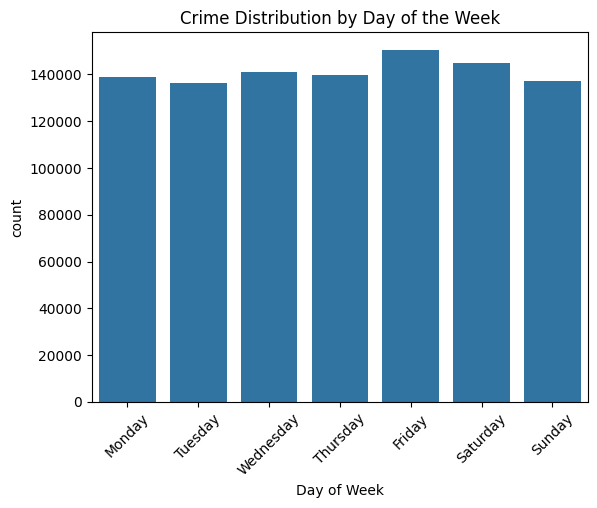

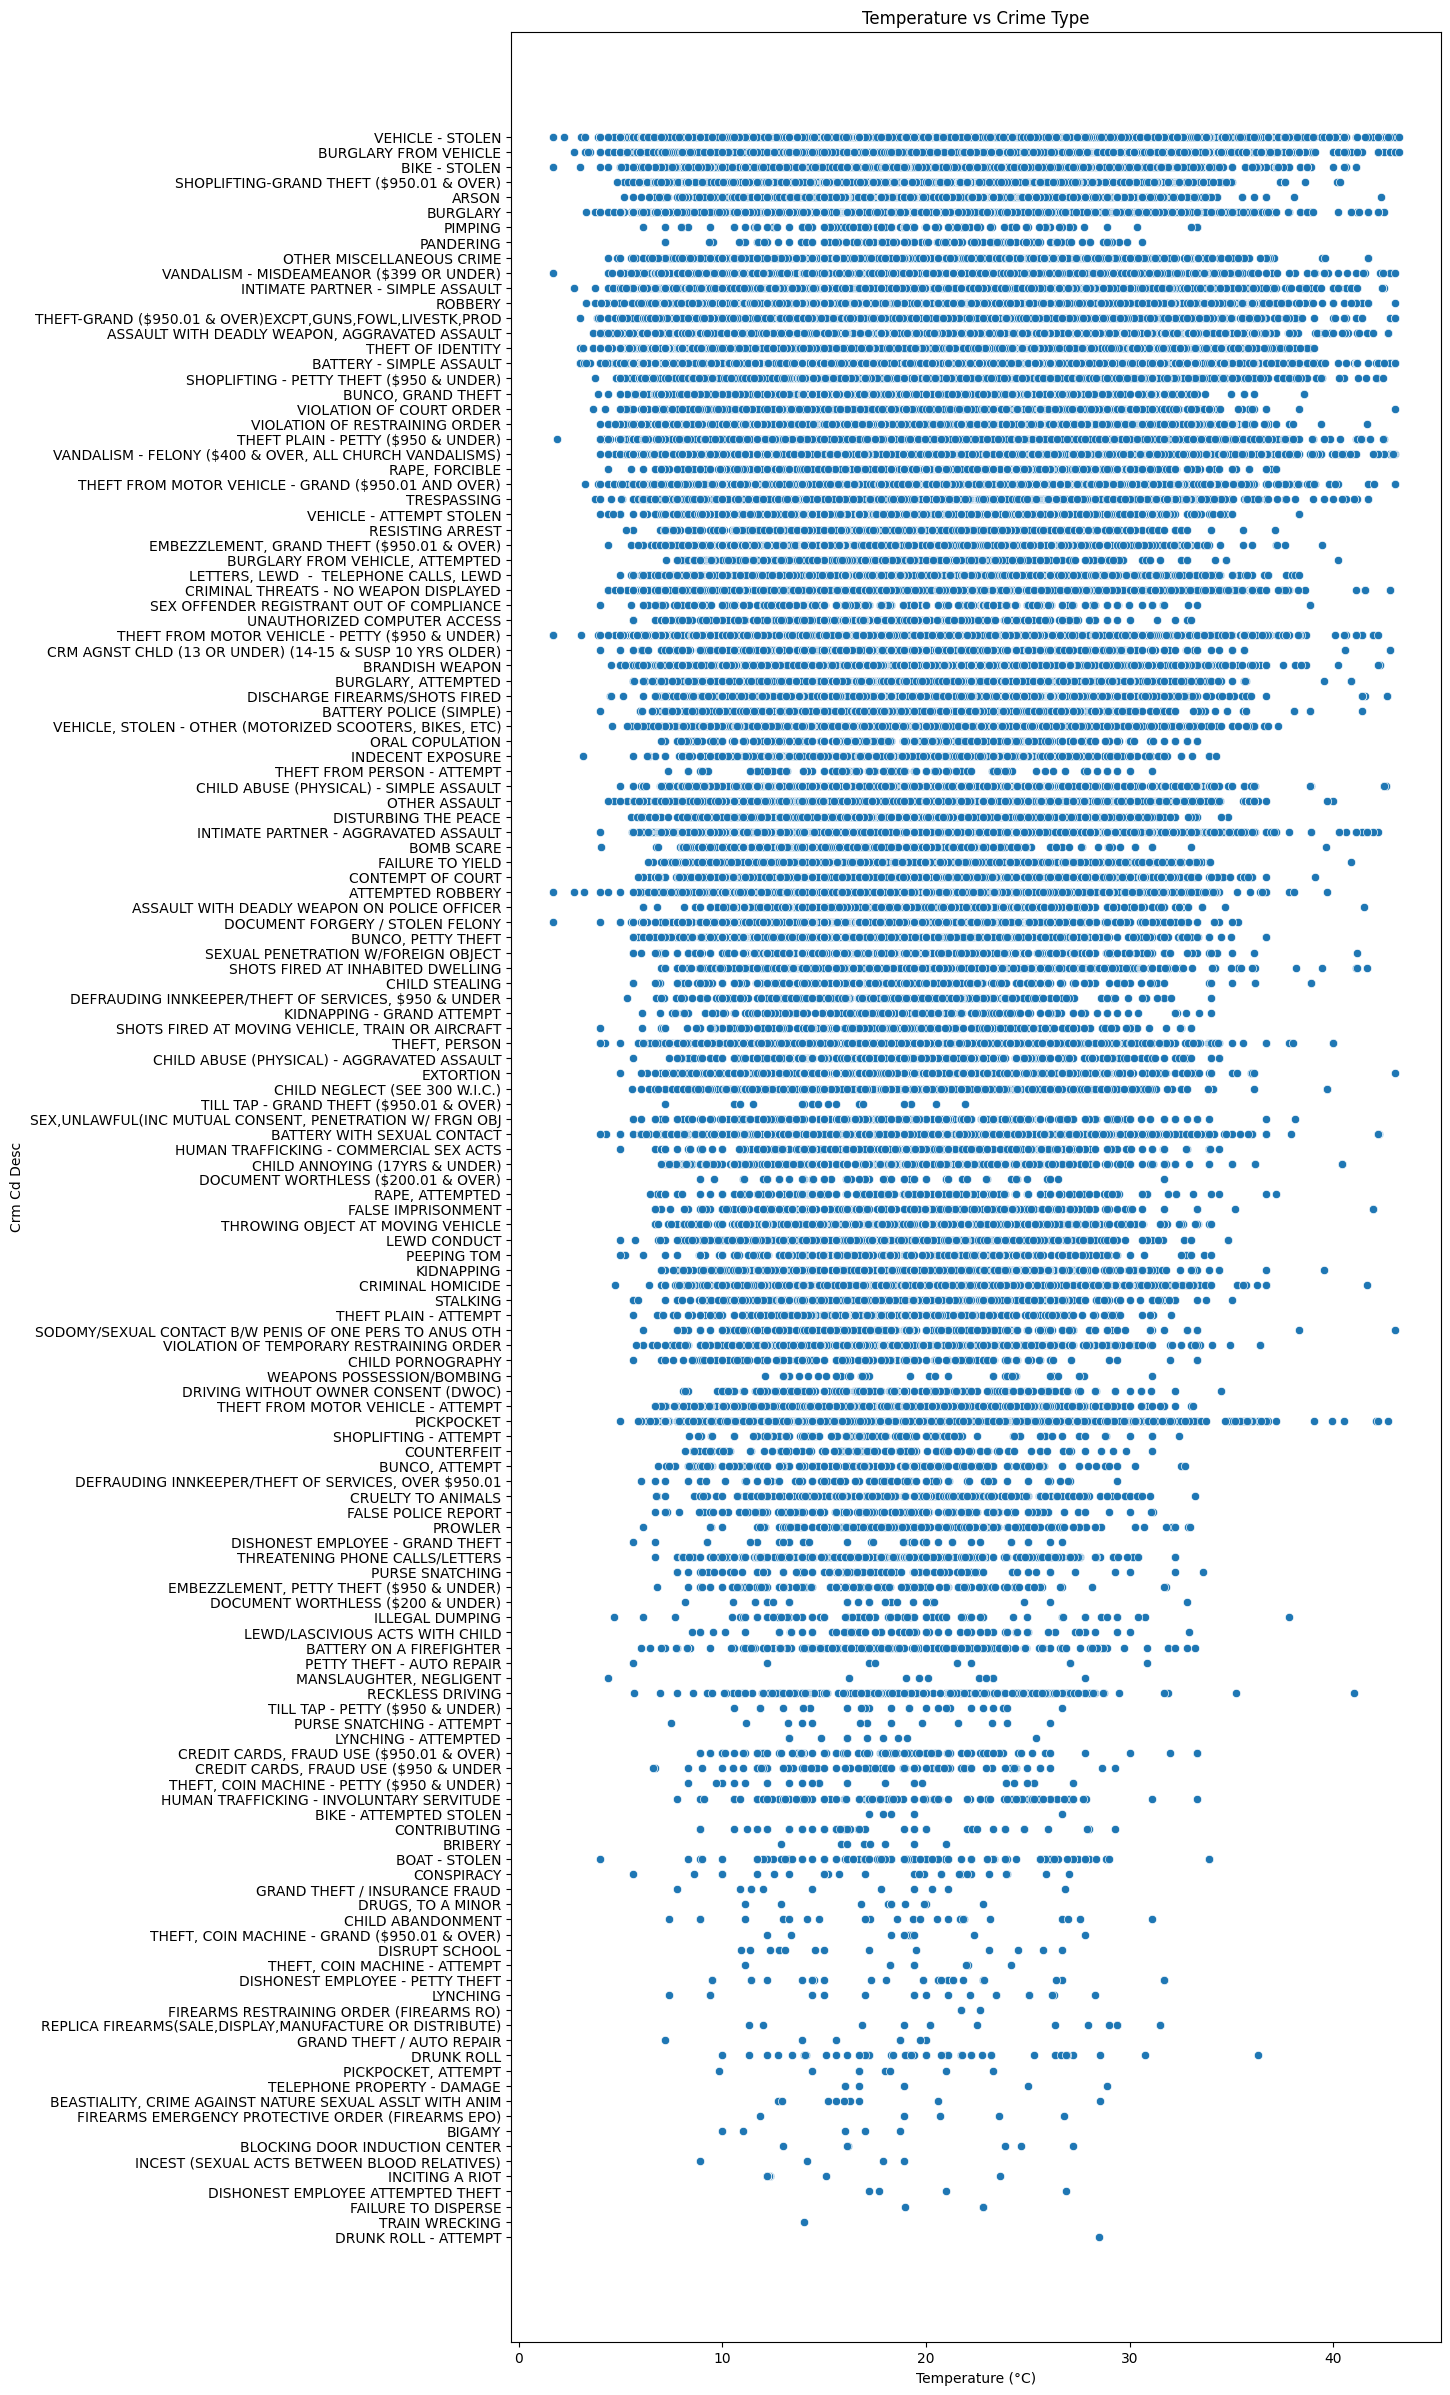

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date/Time' is a datetime object
merged_df['Date/Time'] = pd.to_datetime(merged_df['Date/Time'], errors='coerce')


# Plot crime distribution by day of the week
merged_df['Day of Week'] = merged_df['Date/Time'].dt.day_name()
sns.countplot(data=merged_df, x='Day of Week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Crime Distribution by Day of the Week')
plt.xticks(rotation=45)
plt.show()

# Temperature vs Crime (Scatter plot)
plt.figure(figsize=(12,30))
sns.scatterplot(x=merged_df['Temperature (°C)'], y=merged_df['Crm Cd Desc'])
plt.title('Temperature vs Crime Type')
plt.show()
